<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<H4 align='center'> Integrantes: Pablo Aguirre, Rol: 201473555-3; Jorge Aliste, Rol: 201473538-3 </H4>
<hr style="height:2px;border:none"/>

## Pregunta 4: Entendimiento de imágenes de personas.

El objetivo de esta pregunta es lograr predecir la edad de una persona a través de una foto de ella. Para esto se usarán representaciones de características extraídas y se compararán distintos modelos usando como métrica el error cuadrado medio (MSE).

<img src="https://i.imgur.com/6B072GE.jpg" width="60%" height="20%" />

In [1]:
import numpy as np
import scipy.io as sio
import time
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

C:\Users\pablo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


> a) Cargue los dataset de entrenamiento y de pruebas ¿Cuántos datos hay en cada conjunto?

In [2]:
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")

data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]

In [5]:
print("X_train: ",data_train[0].shape)
print("X_test: ",data_test[0].shape)

X_train:  (3500, 14)
X_test:  (1050, 14)


Se cuenta con 3500 registros para el conjunto de entrenamiento y 1050 registros para el conjunto de pruebas.

> b) Elija cuál representación utilizará para trabajar los datos y entregárselos como *input* al modelo de aprendizaje a utilizar, recuerde que puede utilizar una combinación de éstos si lo desea. Además extraiga las salidas/*output* del problema, en este caso, como ya se comentó, la edad. Describa los datos utilizados y la cantidad de datos por rango de edad.

La representación que se utilizará es Fisherface Space ya que usa LDA para reducir la dimensionalidad y es robusta ante variaciones de luz y de expresiones faciales.

In [6]:
#genFeat = data[0]  #it can be used as representation: contextual features
#ageClass = data[1] #target
#ffcoefs = data[3]   #it can be used as representation: fisherface space
#faceGist = data[4]  #it can be used as representation

X_train = data_train[3]
y_train = data_train[1] 

X_test = data_test[3] 
y_test = data_test[1] 

A continuación, se describen los datos utilizados.

In [27]:
X_train.shape

(3500, 37)

Cada registro cuenta con 37 atributos.

In [7]:
np.unique(y_train)

array([ 1,  5, 10, 16, 28, 51, 75], dtype=uint8)

Se tienen 7 clases: 1, 5, 10, 16, 28, 51, 75.

In [8]:
diccio = {
    1: 0,
    5: 0,
    10: 0,
    16: 0,
    28: 0,
    51: 0,
    75: 0   
}

for elemento in y_train:
    diccio[elemento[0]] += 1
for elemento in y_test:
    diccio[elemento[0]] += 1
    
print("Clase '1' tiene", diccio[1], "datos.")
print("Clase '5' tiene", diccio[5], "datos.")
print("Clase '10' tiene", diccio[10], "datos.")
print("Clase '16' tiene", diccio[16], "datos.")
print("Clase '28' tiene", diccio[28], "datos.")
print("Clase '51' tiene", diccio[51], "datos.")
print("Clase '75' tiene", diccio[75], "datos.")

Clase '1' tiene 650 datos.
Clase '5' tiene 650 datos.
Clase '10' tiene 650 datos.
Clase '16' tiene 650 datos.
Clase '28' tiene 650 datos.
Clase '51' tiene 650 datos.
Clase '75' tiene 650 datos.


Como se puede ver, todas las clases cuentan con la misma cantidad de datos.

> c) Defina y entrene modelos de aprendizaje para la inferencia de la edad de la persona a través de la representación escogida, *se espera que experimente con distintas configuraciones, modelos e hiper-parámetros* . Intente llegar a un *MSE* menor a 100 sobre la edad de las personas en el conjunto de pruebas. Recuerde que **NO** puede seleccionar modelos a través del conjunto de pruebas. Visualice sus resultados si estima conveniente.

Es necesario convertir los vectores de las clases usando `ravel()` ya que SVR no acepta los vectores actuales. Lo que hace `ravel()` es convertir un vector de forma [ [5], [1], [3] ] a un vector de forma [5, 1, 3]. Por otra parte, se compararán modelos usando X normalizado y X sin normalizar.

In [9]:
y_train_transf = np.ravel(y_train)
y_test_transf = np.ravel(y_test)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

### Primer Modelo: SVR

El primer modelo por entrenar será una SVR (Support Vector Regression) con kernel RBF para obtener fronteras no lineales. Primero se graficará el MSE para cada SVR variando el parámetro de regularización `C`.

In [10]:
start = time.time()

Cs = [0.001,0.1,1,1000, 10000]

erroresTrainSVR = []
erroresValSVR = []

erroresTrainSVRstd = []
erroresValSVRstd = []

for c in Cs:
    modelSVR_prueba = SVR(kernel="rbf", C=c)
    modelSVR_prueba.fit(X_train, y_train_transf)
    
    modelSVR_prueba_std = SVR(kernel="rbf", C=c, epsilon = 0.001)
    modelSVR_prueba_std.fit(X_train_std, y_train_transf)
    
    cv_resultsSVR_prueba = cross_validate(modelSVR_prueba, X=X_train, y=y_train_transf, cv=10, scoring="neg_mean_squared_error", n_jobs = -1, return_train_score=True)
    cv_resultsSVR_prueba_std = cross_validate(modelSVR_prueba_std, X=X_train_std, y=y_train_transf, cv=10, scoring="neg_mean_squared_error", n_jobs = -1, return_train_score=True)
    
    erroresTrainSVR.append(-1*np.mean(cv_resultsSVR_prueba["train_score"]))
    erroresValSVR.append(-1*np.mean(cv_resultsSVR_prueba["test_score"]))
    
    erroresTrainSVRstd.append(-1*np.mean(cv_resultsSVR_prueba_std["train_score"]))
    erroresValSVRstd.append(-1*np.mean(cv_resultsSVR_prueba_std["test_score"]))
    
print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos") 

Tiempo que tarda en ejecutarse: 104.1 segundos


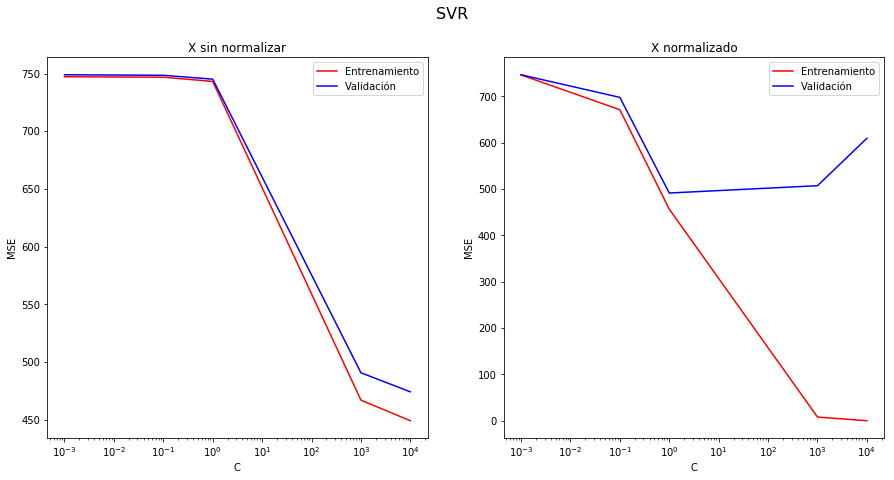

In [11]:
plt.close('all')

plt.figure(figsize=(15,7))
plt.suptitle("SVR", size=16)
plt.subplot(121)
ax = plt.gca()
ax.plot(Cs, erroresTrainSVR, color='red', label= 'Entrenamiento')
ax.plot(Cs, erroresValSVR, color='blue', label='Validación')
ax.set_xscale('log')
plt.xlabel("C")
plt.ylabel("MSE")
plt.title("X sin normalizar")
plt.legend(loc='best')

plt.subplot(122)
ax = plt.gca()
ax = plt.gca()
ax.plot(Cs, erroresTrainSVRstd, color='red', label= 'Entrenamiento')
ax.plot(Cs, erroresValSVRstd, color='blue', label='Validación')
ax.set_xscale('log')
plt.xlabel("C")
plt.ylabel("MSE")
plt.title("X normalizado")
plt.legend(loc='best')

plt.show()

De los gráficos se pueden desprender dos cosas:
+ Normalizar X produce overfitting, por lo que no es recomendable usarlo para el modelo.
+ Aumentar C reduce proporcionalmente el MSE

A continuación, se entrenará una SVR usando C = 10000 para ver en más detalle los errores de entrenamiento y validación. 

In [12]:
modelSVR = SVR(kernel="rbf", C=10000)
modelSVR.fit(X_train, y_train_transf)

SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Para evaluar el modelo se usará validación cruzada con 10 folds.

In [13]:
cv_resultsSVR = cross_validate(modelSVR, X=X_train, y=y_train_transf, cv=10, scoring="neg_mean_squared_error", n_jobs = -1, return_train_score=True)

errorValSVR = -1*np.mean(cv_resultsSVR["test_score"])
errorTrainSVR = -1*np.mean(cv_resultsSVR["train_score"])

print("Error de entrenamiento: %.2f" % (errorTrainSVR))
print("Error de validación: %.2f" % (errorValSVR))

Error de entrenamiento: 449.31
Error de validación: 474.33


### Segundo Modelo: Kernel Ridge Regression

El segundo modelo por utilizar es Kernel Ridge Regression. El parámetro `alpha` se define como $alpha = (2\cdot C)^{-1}$ [[1]](#refs).

In [14]:
start = time.time()

alphas = [1/(2*c) for c in Cs]

erroresTrainKR = []
erroresValKR = []

erroresTrainKRstd = []
erroresValKRstd = []

for a in alphas:
    modelKR_prueba = KernelRidge(kernel="rbf", alpha=a)
    modelKR_prueba.fit(X_train, y_train_transf)
    
    modelKR_prueba_std = KernelRidge(kernel="rbf", alpha=a)
    modelKR_prueba_std.fit(X_train_std, y_train_transf)
    
    cv_resultsKR_prueba = cross_validate(modelKR_prueba, X=X_train, y=y_train_transf, cv=10, scoring="neg_mean_squared_error", n_jobs = -1, return_train_score=True)
    cv_resultsKR_prueba_std = cross_validate(modelKR_prueba_std, X=X_train_std, y=y_train_transf, cv=10, scoring="neg_mean_squared_error", n_jobs = -1, return_train_score=True)
    
    erroresTrainKR.append(-1*np.mean(cv_resultsKR_prueba["train_score"]))
    erroresValKR.append(-1*np.mean(cv_resultsKR_prueba["test_score"]))
    
    erroresTrainKRstd.append(-1*np.mean(cv_resultsKR_prueba_std["train_score"]))
    erroresValKRstd.append(-1*np.mean(cv_resultsKR_prueba_std["test_score"]))
    
print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos") 

Tiempo que tarda en ejecutarse: 77.0 segundos


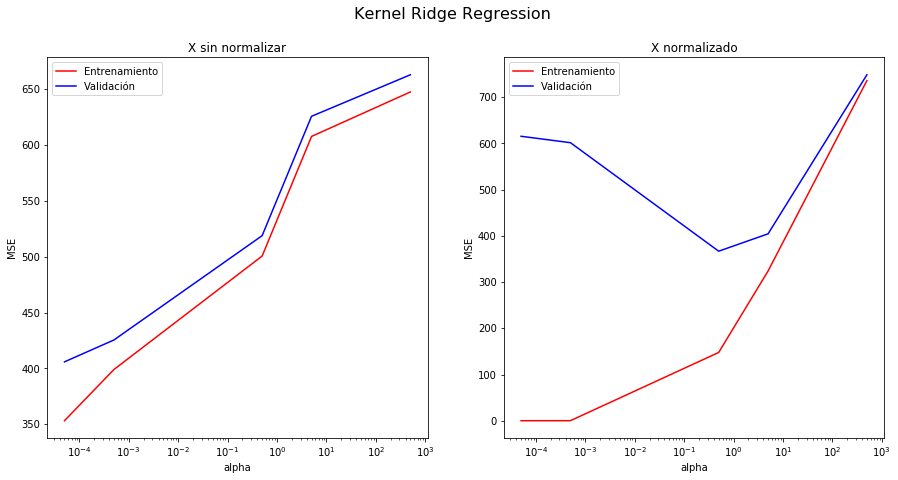

In [15]:
plt.close('all')

plt.figure(figsize=(15,7))
plt.suptitle("Kernel Ridge Regression", size=16)
plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, erroresTrainKR, color='red', label= 'Entrenamiento')
ax.plot(alphas, erroresValKR, color='blue', label='Validación')
ax.set_xscale('log')
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("X sin normalizar")
plt.legend(loc='best')

plt.subplot(122)
ax = plt.gca()
ax = plt.gca()
ax.plot(alphas, erroresTrainKRstd, color='red', label= 'Entrenamiento')
ax.plot(alphas, erroresValKRstd, color='blue', label='Validación')
ax.set_xscale('log')
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("X normalizado")
plt.legend(loc='best')

plt.show()

En este caso, aumentar alpha lleva a un incremento del MSE, lo que es de esperarse ya que alpha se define como el inverso de C. Además, usar X normalizado produce overfitting para valores de alpha menores a 10.

A continuación, se entrenará un modelo usando $alpha = (2 \cdot 10000)^{-1}$ para ver en más detalle los errores de entrenamiento y validación. 

In [16]:
modelKR = KernelRidge(alpha=1/(2*10000), kernel="rbf")
modelKR.fit(X_train, y_train_transf)

KernelRidge(alpha=5e-05, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)

Para evaluar el modelo se usará validación cruzada con 10 folds.

In [17]:
cv_resultsKR = cross_validate(modelKR, X=X_train, y=y_train_transf, cv=10, scoring="neg_mean_squared_error", n_jobs = -1, return_train_score=True)

errorValKR = -1*np.mean(cv_resultsKR["test_score"])
errorTrainKR = -1*np.mean(cv_resultsKR["train_score"])

print("Error de entrenamiento: %.2f" % (errorTrainKR))
print("Error de validación: %.2f" % (errorValKR))

Error de entrenamiento: 353.19
Error de validación: 405.92


### Tercer Modelo: Red Neuronal Feed Forward (Regresión)

El siguiente modelo por probar es una red neuronal feed forward, para esto se trabajará el problema como si fuera de regresión y se usará X sin normalizar debido a los resultados obtenidos anteriormente.

In [18]:
def modelNNR():
    model = Sequential()
    model.add(Dense(512, input_dim=37, kernel_initializer='normal', activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(256, kernel_initializer='normal', activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(128, kernel_initializer='normal', activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_initializer='normal', activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mse', optimizer='RMSprop')
    return model

estimadorNNR = KerasRegressor(build_fn=modelNNR, epochs=100, batch_size=256, verbose=0)

kfold = KFold(n_splits=10, random_state=15)
resultsNNR = cross_val_score(estimadorNNR, X_train, y_train_transf, cv=kfold, scoring="neg_mean_squared_error")
print("Error de validación: %.2f" % (-1*np.mean(resultsNNR)))

Error de validación: 395.43


### Cuarto Modelo: Red Neuronal Feed Forward (Clasificación)

Por último, se usará una red neuronal feed forward pero esta vez se abordará el problema como uno de clasificación.

In [19]:
clases = np.unique(y_train_transf)
print(clases)

[ 1  5 10 16 28 51 75]


El primer paso es convertir las clases de representación entera a representación categórica (one-hot encode).

In [20]:
y_train_one_hot = to_categorical(y_train_transf)
y_test_one_hot = to_categorical(y_test_transf)

print("Representacion entera: ", y_train_transf[1])
print("Representacion categórica: ", y_train_one_hot[1])

Representacion entera:  28
Representacion categórica:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


En esta nueva representación se crea un arreglo de tamaño 76, inicializado con ceros, y se coloca un 1 en el índice correspondiente a la representación entera. En el ejemplo anterior, la representación entera es 28 y la representación categórica tiene un 1 en el índice 28.

A continuación, se crea el modelo.

In [21]:
def modelNNC():
    model = Sequential()
    model.add(Dense(512, input_dim=37, kernel_initializer='normal', activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(256, kernel_initializer='normal', activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(128, kernel_initializer='normal', activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_initializer='normal', activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(76, kernel_initializer='normal', activation="softmax"))

    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    return model

estimadorNNC = KerasClassifier(build_fn=modelNNC, epochs=100, batch_size=256, verbose=0)

kfold = KFold(n_splits=10, random_state=15)
resultsNNC = cross_val_score(estimadorNNC, X_train, y_train_one_hot, cv=kfold)
print("Accuracy validación: %.2f%%" % (100*np.mean(resultsNNC)))

Accuracy validación: 38.11%


El accuracy obtenido es bastante bajo por lo que se espera que al traducirlo a MSE se obtenga un valor alto. 

In [22]:
estimadorNNC.fit(X_train, y_train_one_hot)
y_pred_NNC = estimadorNNC.predict(X_test) 

Notar que `KerasClassifier()` convierte automáticamente la predicción de representación categórica a representación entera.

In [29]:
y_pred_NNC

array([ 1, 51, 28, ..., 10, 10, 16])

En resumen, se obtuvieron las siguientes métricas al evaluar los modelos.

In [23]:
print("SVR:")
print("Error de entrenamiento: %.2f" % (errorTrainSVR))
print("Error de validación: %.2f" % (errorValSVR))
print("")
print("Kernel Ridge Regression:")
print("    Error de entrenamiento: %.2f" % (errorTrainKR))
print("    Error de validación: %.2f" % (errorValKR))
print("")
print("Red Neuronal Regresión: ")
print("    Error de validación: %.2f" % (-1*np.mean(resultsNNR)))
print("")
print("Red Neuronal Clasificación: ")
print("    Accuracy validación: %.2f%%" % (100*np.mean(resultsNNC)))

SVR:
Error de entrenamiento: 449.31
Error de validación: 474.33

Kernel Ridge Regression:
    Error de entrenamiento: 353.19
    Error de validación: 405.92

Red Neuronal Regresión: 
    Error de validación: 395.43

Red Neuronal Clasificación: 
    Accuracy validación: 38.11%


El menor MSE se obtuvo con la red neuronal usando regresión. El error de test para este modelo es

In [24]:
estimadorNNR.fit(X_train, y_train_transf)
y_predNNR = estimadorNNR.predict(X_test)

print("Error de test: %.2f" % (mean_squared_error(y_test_transf, y_predNNR)))

Error de test: 404.11


A modo de comparación, el error de test para la red neuronal usando clasificación es

In [25]:
print("Error de test: %.2f" % (mean_squared_error(y_test_transf, y_pred_NNC)))

Error de test: 489.23


El cual es bastante mayor y va de la mano con el accuracy obtenido. A modo de conclusión, en general las redes neuronales son capaces de generalizar mejor a partir de los datos. Es posible disminuir aún más el MSE pero hay que jugar con la cantidad de capas de la red y la cantidad de neuronas en cada una de ellas.

<a id="refs"></a>
## Referencias
[1] Sklearn: Kernel Ridge https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html